In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np

In [2]:
import urllib
params ='DRIVER={SQL Server};SERVER=CL-AMILAH\AMILA;DATABASE=GSH;UID=Amila;Trusted_Connection=yes;'             
params = urllib.parse.quote_plus(params)

from sqlalchemy import create_engine
db = create_engine('mssql+pyodbc:///?odbc_connect=%s' % params)

# Load sales data

In [3]:
sql = '''
SELECT inv.[ID] ,inv.SiteUID, [Date] , [OutletUID] ,ot.Name AS outlet ,ot.ProvinceUID,pr.Description AS province ,ot.DistrictUID ,  di.Description AS district 
, ot.AreaUID , ar.Description AS Area , inv.[AgentUID] ,Concat(emp.FirstName ,' ' , emp.MiddleInitials , ' ', emp.LastName ) AS AgentName , inv.[DistributorUID] , d.Name AS distributor, [ItemUID] ,it.Description AS item, [UnitQty] 
, [UnitPrice] , [RetailUnitPrice] , [FreeQty] , [FreeCompanyQty] , [GrossValue]
,datename(YEAR, Date) AS Year
,datename(month, Date) AS MonthName
,MONTH(Date) AS Month
,datename(DAY, Date) AS Day
,DATEPART(DW,Date) AS WeekDay
,datename(WEEKDAY, Date) AS DateName
,DATEPART (hh,Date) as Hour

  FROM [GSH].[dbo].[vw_Invoice] inv
  LEFT JOIN [GSH].[dbo].[vw_InvoiceLine] invl
  ON inv.siteUID = invl.TxnInvoice_SiteUID AND inv.uid = invl.TxnInvoiceUID	
  LEFT JOIN [GSH].[dbo].[Item] it
  ON invl.ItemUID = it.UID
  LEFT JOIN [GSH].[dbo].[Outlet] ot
  ON inv.OutletUID = ot.UID
  LEFT JOIN [GSH].[dbo].[Area] pr
  ON ot.ProvinceUID = pr.UID
  LEFT JOIN [GSH].[dbo].[Area] di
  ON ot.DistrictUID = di.UID
  LEFT JOIN [GSH].[dbo].[Area] ar
  ON ot.AreaUID = ar.UID
  LEFT JOIN [GSH].[dbo].[Distributor] d
  ON inv.DistributorUID = d.UID
  LEFT JOIN [GSH].[dbo].[avLogin] avlg
  ON inv.AgentUID = avlg.BusinessUserUID
  LEFT JOIN [GSH].[dbo].[Employee] emp
  ON avlg.EmployeeUID = emp.UID
  WHERE inv.mpt_TypeEnum IN ( 21 , 44, 14, 1) AND inv.ExpiryDate IS NULL AND inv.SubmittedDate IS NOT NULL
  AND Date >= '2018-11-01' AND Date <= '2020-03-01' ;
'''

invoice_All = pd.read_sql_query(sql, db)

In [4]:
#disply all the columns
pd.set_option('display.max_columns', None)

In [5]:
 #get date from date time
invoice_All['just_date'] = invoice_All['Date'].dt.date
#Get month Start Date 
invoice_All['start_month'] = invoice_All['Date'].to_numpy().astype('datetime64[M]')

In [6]:
invoice_All.head()

,ID,SiteUID,Date,OutletUID,outlet,ProvinceUID,province,DistrictUID,district,AreaUID,Area,AgentUID,AgentName,DistributorUID,distributor,ItemUID,item,UnitQty,UnitPrice,RetailUnitPrice,FreeQty,FreeCompanyQty,GrossValue,Year,MonthName,Month,Day,WeekDay,DateName,Hour,just_date,start_month
0,CSO011701378,54,2018-11-02 07:57:45.397,372,HEALTHY CARE PHARMACY,24.0,North Western Province,26.0,Puttalam,92.0,CHILAW,117,,2,The West Central Pharma (Pvt) Ltd.,42,Losartan 25mg,10.0,193.40,220.5,0.0,0.0,1934.0,2018,November,11,2,6,Friday,7,2018-11-02,2018-11-01
1,CSO011701378,54,2018-11-02 07:57:45.397,372,HEALTHY CARE PHARMACY,24.0,North Western Province,26.0,Puttalam,92.0,CHILAW,117,,2,The West Central Pharma (Pvt) Ltd.,42,Losartan 25mg,0.0,193.40,220.5,1.0,1.0,0.0,2018,November,11,2,6,Friday,7,2018-11-02,2018-11-01
2,CSO011801116,55,2018-11-02 08:00:16.220,3359,Dr.Chaminda Mendis,20.0,Western Province,23.0,Gampaha,95.0,Kandana,118,,2,The West Central Pharma (Pvt) Ltd.,87,Klatril Tab's 500mg 14's,50.0,657.65,749.7,0.0,0.0,32882.5,2018,November,11,2,6,Friday,8,2018-11-02,2018-11-01
3,CSO011801116,55,2018-11-02 08:00:16.220,3359,Dr.Chaminda Mendis,20.0,Western Province,23.0,Gampaha,95.0,Kandana,118,,2,The West Central Pharma (Pvt) Ltd.,87,Klatril Tab's 500mg 14's,0.0,657.65,749.7,5.0,5.0,0.0,2018,November,11,2,6,Friday,8,2018-11-02,2018-11-01
4,CSO011200326,94,2018-11-01 16:46:28.790,1768,Star Pharmacy,16.0,Southern Province,17.0,Galle,269.0,Devata,112,Kulathunga Sadish,18,New Loyed Pharmacy,6,Pernex Ac 5 PCT Gel 20gm,1.0,396.00,451.5,0.0,0.0,396.0,2018,November,11,1,5,Thursday,16,2018-11-01,2018-11-01


In [7]:
#Aggregate data into weekly sum
sample=invoice_All[['Date','UnitQty','FreeQty','FreeCompanyQty']]
weekly=sample.resample('W', on='Date').sum()

In [8]:
#sum free quantities
column_names = ['FreeQty','FreeCompanyQty']
weekly['Free_Total']= weekly[column_names].sum(axis=1)

In [9]:
weekly

,UnitQty,FreeQty,FreeCompanyQty,Free_Total
Date,,,,
2018-11-04,19463.0,4307.0,4320.0,8627.0
2018-11-11,88483.0,15484.0,15833.0,31317.0
2018-11-18,106453.0,17015.0,17152.0,34167.0
2018-11-25,62137.0,9349.0,9590.0,18939.0
2018-12-02,207574.0,45798.0,46681.0,92479.0
...,...,...,...,...
2020-02-02,204751.0,32713.0,34702.0,67415.0
2020-02-09,61409.0,8562.0,8950.0,17512.0
2020-02-16,114326.0,17478.0,17691.0,35169.0


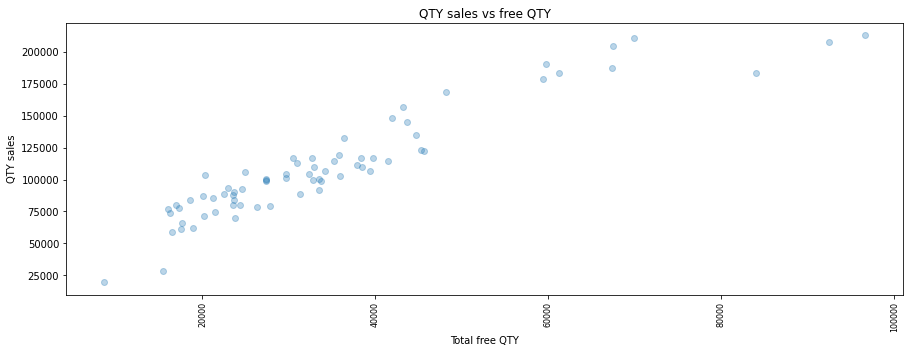

In [19]:
plt.scatter(weekly.Free_Total , weekly.UnitQty , alpha=0.3,cmap='viridis')
plt.xlabel("Total free QTY")
plt.xticks (rotation='vertical', size=8)
plt.ylabel("QTY sales")
plt.title("QTY sales vs free QTY")
plt.rcParams['figure.figsize'] = [15, 5]
plt.show()

### Invoice free sales behaviour

In [11]:
#Aggregate data into Invoice sum
Invoice=invoice_All.groupby("ID").agg({'UnitQty':'sum','FreeQty':'sum','FreeCompanyQty':'sum'}).reset_index()

In [12]:
#sum free quantities
column_names = ['FreeQty','FreeCompanyQty']
Invoice['Free_Total']= Invoice[column_names].sum(axis=1)

In [13]:
Invoice

,ID,UnitQty,FreeQty,FreeCompanyQty,Free_Total
0,BO0081000081,10.0,1.0,1.0,2.0
1,BO0081000107,2.0,0.0,0.0,0.0
2,BO0081000146,1.0,0.0,0.0,0.0
3,BO0081000147,2.0,0.0,0.0,0.0
4,BO0081000148,5.0,0.0,0.0,0.0
...,...,...,...,...,...
195005,IN0190000001,351.0,7.0,7.0,14.0
195006,IN0190000003,30.0,3.0,3.0,6.0
195007,IN0190000005,10.0,10.0,10.0,20.0
195008,IN0190000006,20.0,0.0,0.0,0.0


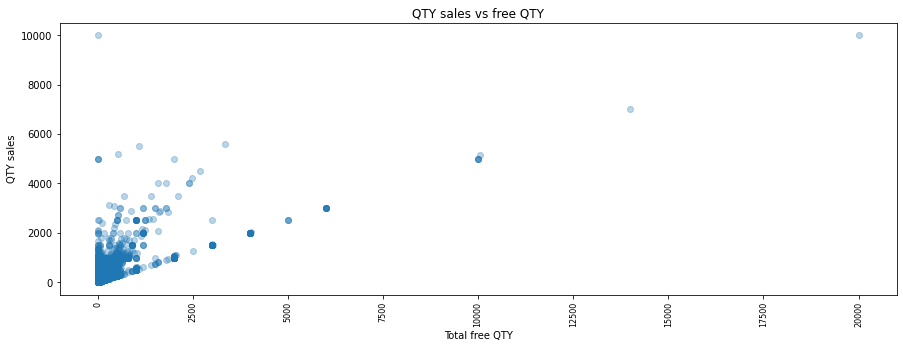

In [14]:
plt.scatter(Invoice.Free_Total , Invoice.UnitQty , alpha=0.3,cmap='viridis')
plt.xlabel("Total free QTY")
plt.xticks (rotation='vertical', size=8)
plt.ylabel("QTY sales")
plt.title("QTY sales vs free QTY")
plt.rcParams['figure.figsize'] = [15, 5]
plt.show()

In [15]:
Invoice_sec = Invoice.loc[(Invoice['Free_Total'] <= 4000) & (Invoice['UnitQty'] <= 6000)]

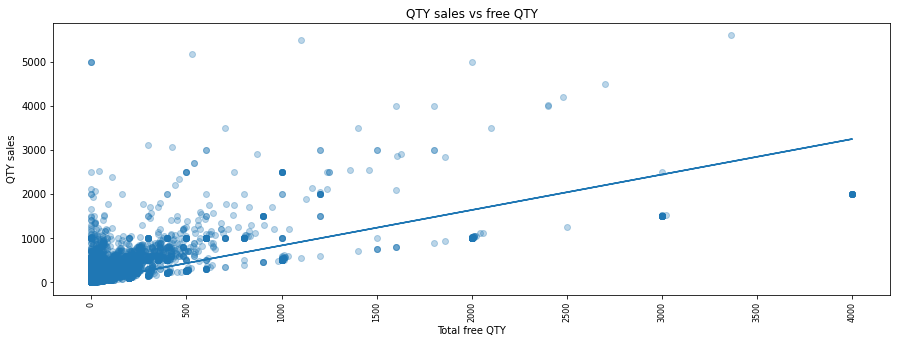

In [16]:
plt.scatter(Invoice_sec.Free_Total , Invoice_sec.UnitQty , alpha=0.3,cmap='viridis')
plt.xlabel("Total free QTY")
plt.xticks (rotation='vertical', size=8)
plt.ylabel("QTY sales")
plt.title("QTY sales vs free QTY")
plt.rcParams['figure.figsize'] = [15, 5]

# m = slope, b=intercept
m, b = np.polyfit(Invoice_sec.Free_Total,Invoice_sec.UnitQty, 1)
# y = mx +c
plt.plot(Invoice_sec.Free_Total, m*Invoice_sec.Free_Total + b)


plt.show()

In [17]:
Invoice_sec

,ID,UnitQty,FreeQty,FreeCompanyQty,Free_Total
0,BO0081000081,10.0,1.0,1.0,2.0
1,BO0081000107,2.0,0.0,0.0,0.0
2,BO0081000146,1.0,0.0,0.0,0.0
3,BO0081000147,2.0,0.0,0.0,0.0
4,BO0081000148,5.0,0.0,0.0,0.0
...,...,...,...,...,...
195005,IN0190000001,351.0,7.0,7.0,14.0
195006,IN0190000003,30.0,3.0,3.0,6.0
195007,IN0190000005,10.0,10.0,10.0,20.0
195008,IN0190000006,20.0,0.0,0.0,0.0


In [18]:
Invoice_sec.corr(method ='pearson')

,UnitQty,FreeQty,FreeCompanyQty,Free_Total
UnitQty,1.000000,0.670031,0.677471,0.674359
FreeQty,0.670031,1.000000,0.996484,0.999114
FreeCompanyQty,0.677471,0.996484,1.000000,0.999128
Free_Total,0.674359,0.999114,0.999128,1.000000
